In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indic-tts-deepfake-challenge/sample.csv


In [2]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 71.5 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0


In [3]:
# Install dependencies
!pip install librosa xgboost datasets scikit-learn matplotlib seaborn pandas numpy tqdm

In [4]:
import numpy as np
import pandas as pd
import librosa
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

In [5]:
# Set random seed
#np.random.seed(42)

In [6]:
# Step 1: Load dataset with streaming
try:
    dataset = load_dataset("SherryT997/IndicTTS-Deepfake-Challenge-Data", streaming=True)
    train_dataset = dataset["train"]
    test_dataset = dataset["test"]
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

README.md:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

In [7]:
# Step 2: Define feature extraction function
def extract_audio_features(audio_array, sampling_rate, max_length=160000):  # 10s at 16kHz
    try:
        # Resample to 16kHz if needed
        if sampling_rate != 16000:
            audio_array = librosa.resample(audio_array, orig_sr=sampling_rate, target_sr=16000)
            sampling_rate = 16000

        # Truncate/pad to 10s
        if len(audio_array) > max_length:
            audio_array = audio_array[:max_length]
        else:
            audio_array = np.pad(audio_array, (0, max_length - len(audio_array)), mode='constant')

        # Extract MFCCs (13 coefficients) and their deltas
        mfccs = librosa.feature.mfcc(y=audio_array, sr=sampling_rate, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfccs)

        # Additional features: zero-crossing rate, spectral centroid
        zcr = librosa.feature.zero_crossing_rate(audio_array)[0]
        spec_centroid = librosa.feature.spectral_centroid(y=audio_array, sr=sampling_rate)[0]

        # Aggregate features (mean and std across time)
        features = np.concatenate([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),  # MFCC mean/std
            np.mean(mfcc_delta, axis=1), np.std(mfcc_delta, axis=1),  # Delta mean/std
            [np.mean(zcr), np.std(zcr), np.mean(spec_centroid), np.std(spec_centroid)]  # ZCR, centroid
        ])
        return features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return np.zeros(34)  # 13 + 13 + 4 = 34 features

In [8]:
# Step 3: Process dataset (10% trial run for train)
#subset_size = 0.01  # ~3K samples
subset_size = 1  # 31K samples
train_features = []
train_labels = []
train_ids = []

In [9]:
# Extract features for training subset
print("Extracting features for training subset...")
#for sample in tqdm(list(train_dataset.take(int(31000 * subset_size))), desc="Train Features"):
for i, sample in tqdm(enumerate(train_dataset), total=int(31000 * subset_size), desc="Train Features"):
    audio_array = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]
    features = extract_audio_features(audio_array, sampling_rate)
    train_features.append(features)
    train_labels.append(sample["is_tts"])
    train_ids.append(sample["id"])

Extracting features for training subset...


Train Features: 31102it [30:39, 16.91it/s]                             


In [10]:
# Convert to numpy arrays
X_train_full = np.array(train_features)
y_train_full = np.array(train_labels)

In [11]:
# Split into train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

In [12]:
# Step 4: Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1
)

In [13]:
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)

Training XGBoost model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [14]:
# Step 5: Evaluate on train and validation sets
train_preds = xgb_model.predict_proba(X_train)[:, 1]
val_preds = xgb_model.predict_proba(X_val)[:, 1]

In [15]:
train_auc = roc_auc_score(y_train, train_preds)
val_auc = roc_auc_score(y_val, val_preds)
print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.9809
Validation ROC-AUC: 0.9497


In [16]:
# Visualization: ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, train_preds)
fpr_val, tpr_val, _ = roc_curve(y_val, val_preds)

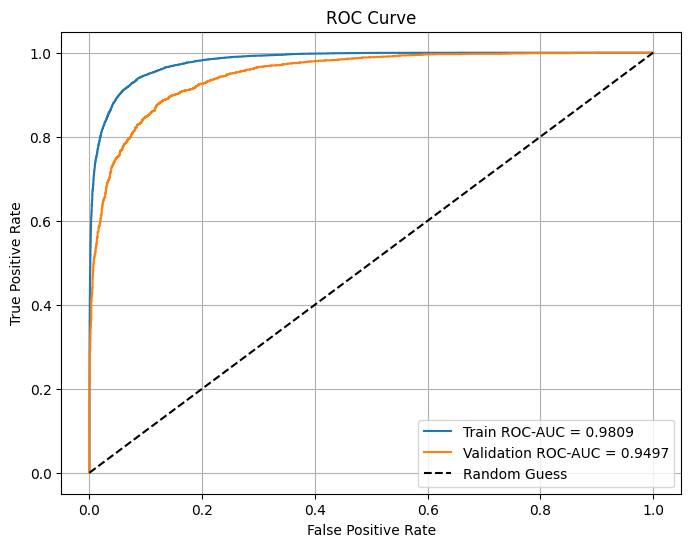

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC-AUC = {train_auc:.4f}")
plt.plot(fpr_val, tpr_val, label=f"Validation ROC-AUC = {val_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig("roc_curve.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


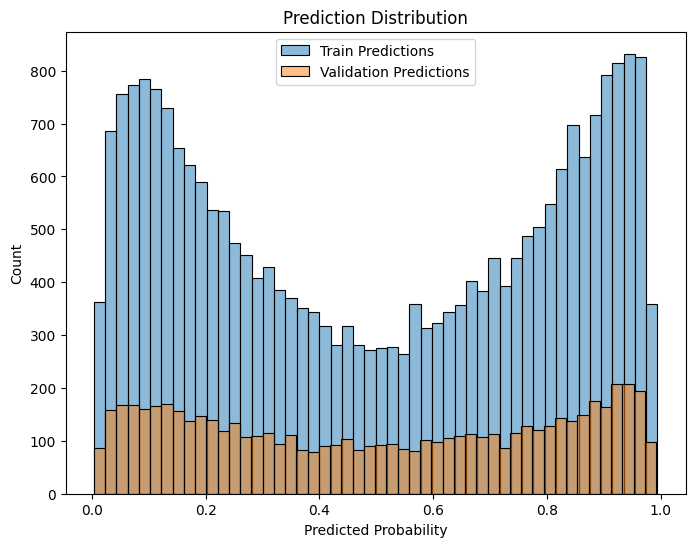

In [18]:
# Visualization: Prediction Distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_preds, bins=50, label="Train Predictions", alpha=0.5)
sns.histplot(val_preds, bins=50, label="Validation Predictions", alpha=0.5)
plt.xlabel("Predicted Probability")
plt.title("Prediction Distribution")
plt.legend()
plt.savefig("pred_distribution.png")
plt.show()

In [19]:
# Visualization: Feature Importance
feature_names = (
    [f"mfcc_mean_{i}" for i in range(13)] +
    [f"mfcc_std_{i}" for i in range(13)] +
    [f"mfcc_delta_mean_{i}" for i in range(13)] +
    [f"mfcc_delta_std_{i}" for i in range(13)] +
    ["zcr_mean", "zcr_std", "spec_centroid_mean", "spec_centroid_std"]
)[:34]  # Match feature count

<Figure size 1000x600 with 0 Axes>

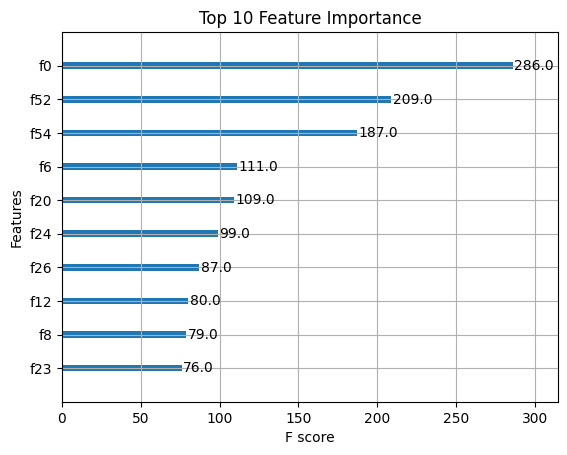

In [20]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importance")
plt.savefig("feature_importance.png")
plt.show()

In [21]:
# Step 6: Process test data
test_features = []
test_ids = []

In [22]:
print("Extracting features for test set...")
for sample in tqdm(list(test_dataset), desc="Test Features"):
    audio_array = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]
    features = extract_audio_features(audio_array, sampling_rate)
    test_features.append(features)
    test_ids.append(sample["id"])

Extracting features for test set...


Test Features: 100%|██████████| 2635/2635 [01:56<00:00, 22.53it/s]


In [23]:
X_test = np.array(test_features)

In [24]:
# Step 7: Predict on test set
test_preds = xgb_model.predict_proba(X_test)[:, 1]

In [25]:
# Step 8: Generate submission
submission = pd.DataFrame({"id": test_ids, "is_tts": test_preds})
submission.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")
print(submission.head())
print(f"Submission shape: {submission.shape}")

Submission saved as submission.csv
                  id    is_tts
0  ASM_F_ANGER_00109  0.699484
1  ASM_F_ANGER_00127  0.906907
2  ASM_F_ANGER_00386  0.800092
3  ASM_F_ANGER_00103  0.909389
4  ASM_F_ANGER_00434  0.445665
Submission shape: (2635, 2)
